In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from pathlib import Path

# Tratamento de Dados

In [152]:
# Defina o caminho para o seu arquivo Excel
file_path = Path('Dados') / 'ISEG_Bloomberg' / 'Dados.xlsx'
assert file_path.exists(), 'Arquivo não encontrado'

In [153]:
# Função para ler e limpar dados de uma folha específica, tratando colunas extras
def read_sheet(sheet_name, col_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=6)
    data = data.iloc[:, [0, 1]]  # Seleciona apenas as duas primeiras colunas relevantes
    data.columns = ['Date', col_name]
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna().set_index('Date')
    data = data.shift(1).dropna()  # Desloca os preços uma linha para baixo
    return data

## Variáveis anteriores (s/ Brent)

In [154]:
# Ler os dados das várias folhas com os nomes das colunas corrigidos, sem o Brent
wti_data = read_sheet('WTI Crude Oil', 'WTI Crude Oil Prices')
sp500_data = read_sheet('S&P500', 'S&P500')
gold_data = read_sheet('Gold', 'Gold')
silver_data = read_sheet('Silver', 'Silver')
eurusd_data = read_sheet('EURUSD', 'EUR/USD')
eurrub_data = read_sheet('EURRUB', 'EUR/RUB')

In [155]:
# Combinar todas as folhas em um único DataFrame
combined_data = wti_data.join([sp500_data, gold_data, silver_data, eurusd_data, eurrub_data], how='outer')
combined_data.dropna(inplace=True)

## Criação da var monthly_avg_price

Para o nosso modelo de classificação, o objetivo será perceber se a média das cotações no 1º dia útil de cada mês foi superior à média das cotações do mês anterior, obtendo o valor de 1 caso seja maior e 0, caso contrário. 

Contudo, terá mais sentido analisar a penúltima 4f de cada mês, ou seja, analisar se a média das cotações na penúltima 4f de cada mês é maior do que a média das cotações do mês anterior. 

No 1º dia útil de cada mês a previsão da média das cotações será muito mais difícil comparado com a penúltima 4f de cada mês, já que nessa situação, teremos sensivelmente dados dos primeiros 10 dias úteis do mês em questão e, posteriormente, podemos usar esses dados para a previsão. 

In [156]:
# Criar a variável 'monthly_average_price' para cada dia útil do mês
combined_data['Monthly Average'] = combined_data['WTI Crude Oil Prices'].resample('ME').transform('mean')
combined_data['Monthly Average'] = combined_data['Monthly Average'].ffill()

In [157]:
combined_data['Previous Month Average'] = combined_data['Monthly Average'].resample("ME").last().shift(1).resample('D').bfill()

In [158]:
combined_data = combined_data.dropna()
combined_data["WTI Target"] = (combined_data["Monthly Average"] > combined_data["Previous Month Average"]).astype(int)

In [159]:
# variable that computes the mean of WTI Price from the beginning of the month until the current day
combined_data["Cumulative Mean"] = 0
for i in combined_data.iterrows():
    ts = i[0]
    start_date = f'{ts.year}-{ts.month}-01'
    end_date = ts
    cum_mean = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]["WTI Crude Oil Prices"].mean()
    combined_data.loc[ts, "Cumulative Mean"] = cum_mean

/tmp/ipykernel_1388313/2922461525.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.92' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_data.loc[ts, "Cumulative Mean"] = cum_mean


In [160]:
combined_data.iloc[:32]

,WTI Crude Oil Prices,S&P500,Gold,Silver,EUR/USD,EUR/RUB,Monthly Average,Previous Month Average,WTI Target,Cumulative Mean
Date,,,,,,,,,,
1994-02-01,15.92,479.62,384.50,5.31,1.1360,1.3732,14.772632,15.052000,0,15.920000
1994-02-02,16.04,482.00,384.90,5.31,1.1311,1.3792,14.772632,15.052000,0,15.980000
1994-02-03,15.89,480.71,387.30,5.44,1.1334,1.3764,14.772632,15.052000,0,15.950000
1994-02-04,15.63,469.81,386.50,5.44,1.1317,1.3785,14.772632,15.052000,0,15.870000
1994-02-07,15.25,471.76,379.60,5.21,1.1157,1.4000,14.772632,15.052000,0,15.746000
1994-02-08,15.21,471.05,380.75,5.28,1.1141,1.4083,14.772632,15.052000,0,15.656667
1994-02-09,14.60,472.77,384.20,5.35,1.1179,1.4035,14.772632,15.052000,0,15.505714
1994-02-10,14.56,468.93,382.75,5.33,1.1194,1.4016,14.772632,15.052000,0,15.387500
1994-02-11,14.72,470.18,381.80,5.00,1.1207,1.3982,14.772632,15.052000,0,15.313333


In [161]:
# Filtrar os dados entre as datas de 1994 e 2024
start_date = '1994-02-01'
end_date = '2024-07-15'
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [162]:
# Exibir os primeiros 5 registros
print(filtered_data.head())

            WTI Crude Oil Prices  S&P500   Gold  Silver  EUR/USD  EUR/RUB  \
Date                                                                        
1994-02-01                 15.92  479.62  384.5    5.31   1.1360   1.3732   
1994-02-02                 16.04  482.00  384.9    5.31   1.1311   1.3792   
1994-02-03                 15.89  480.71  387.3    5.44   1.1334   1.3764   
1994-02-04                 15.63  469.81  386.5    5.44   1.1317   1.3785   
1994-02-07                 15.25  471.76  379.6    5.21   1.1157   1.4000   

            Monthly Average  Previous Month Average  WTI Target  \
Date                                                              
1994-02-01        14.772632                  15.052           0   
1994-02-02        14.772632                  15.052           0   
1994-02-03        14.772632                  15.052           0   
1994-02-04        14.772632                  15.052           0   
1994-02-07        14.772632                  15.052       

## Plotagem dos gráficos das variáveis

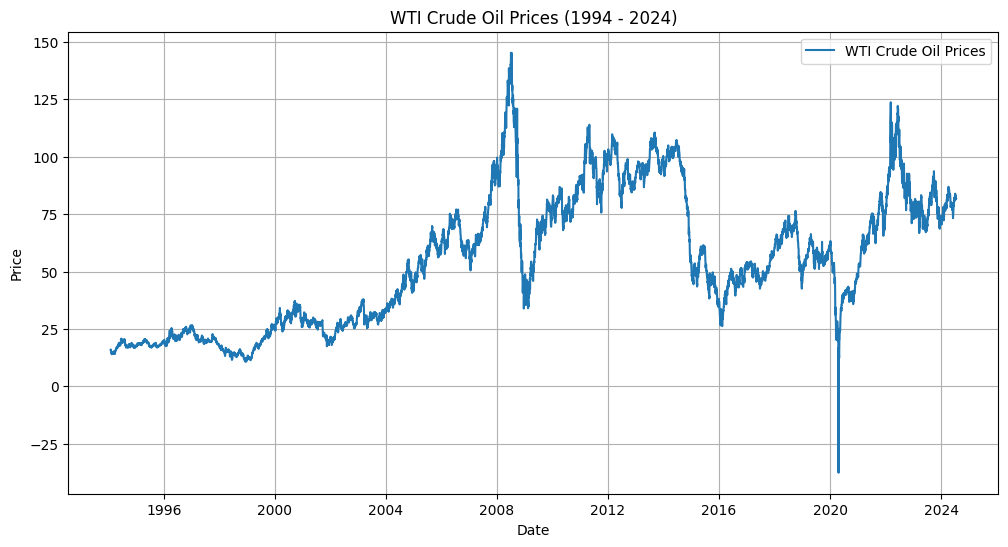

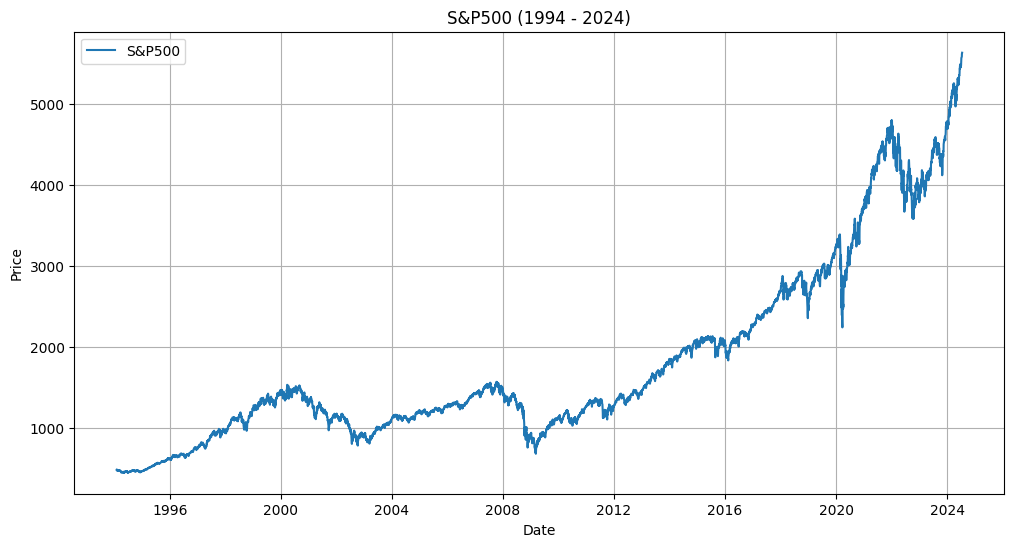

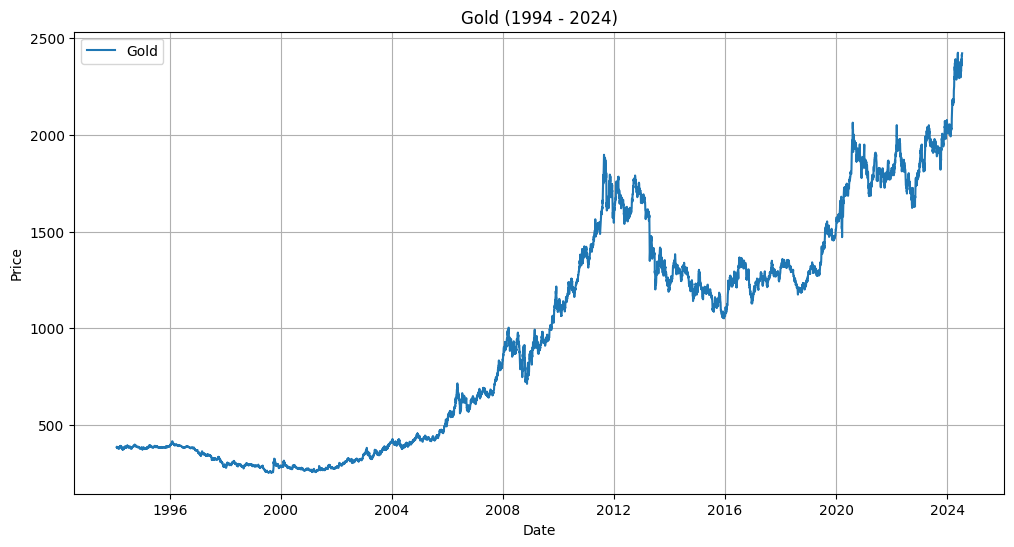

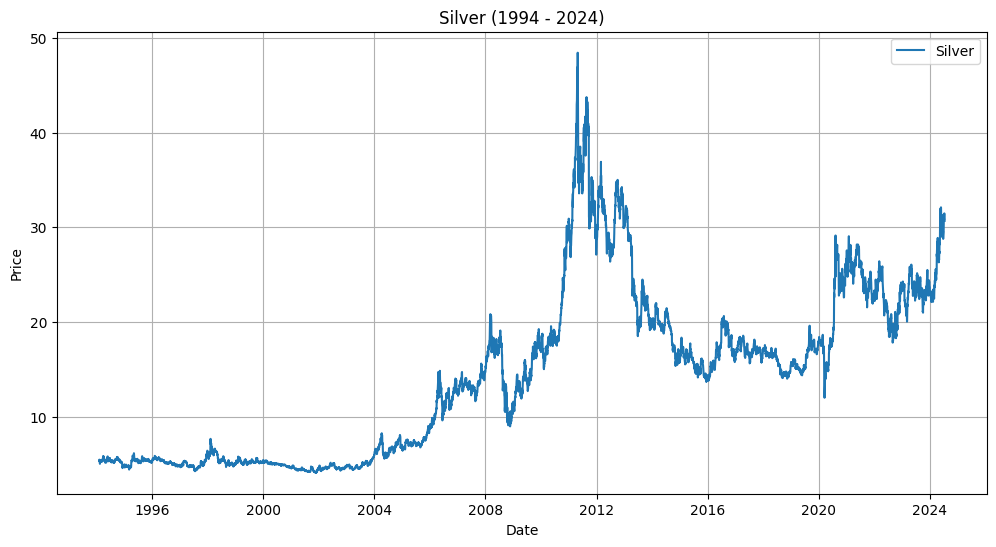

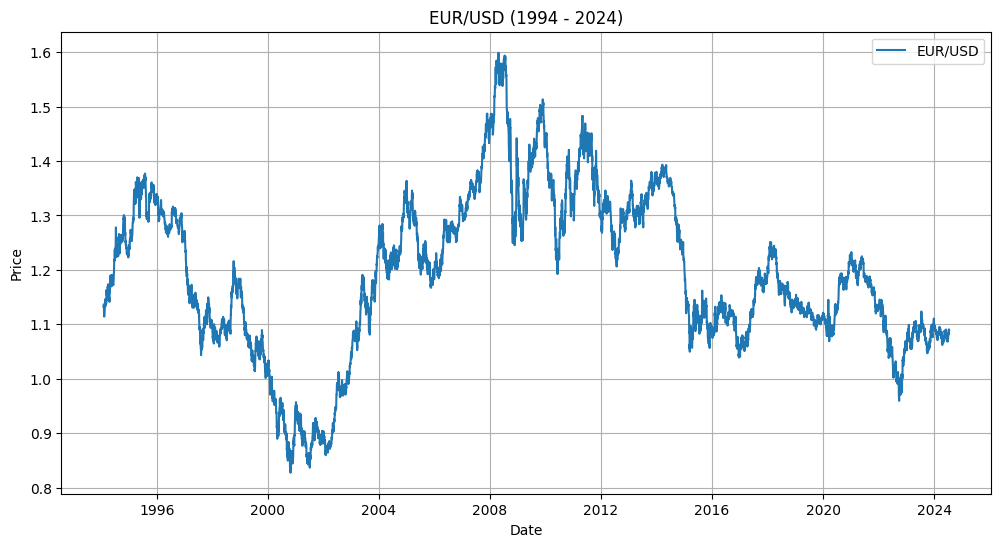

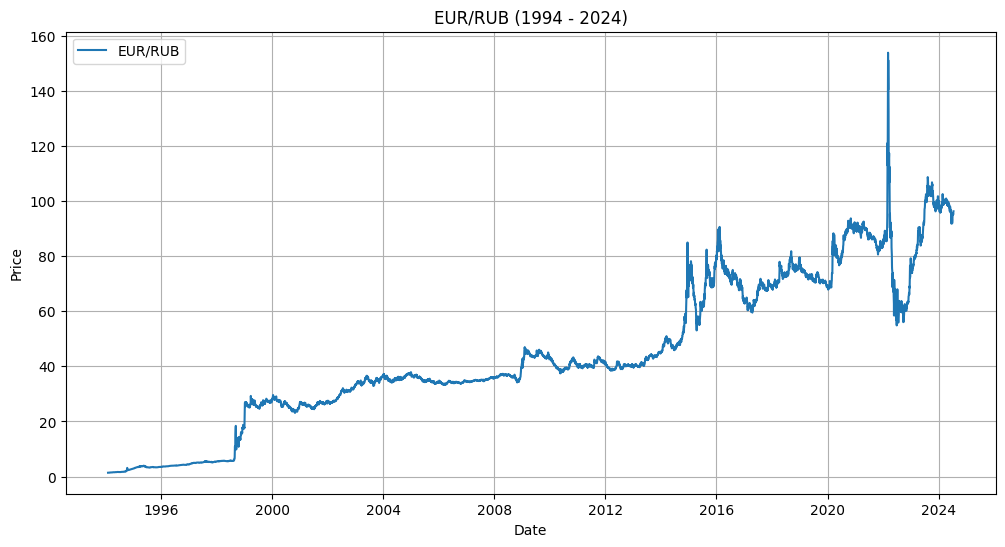

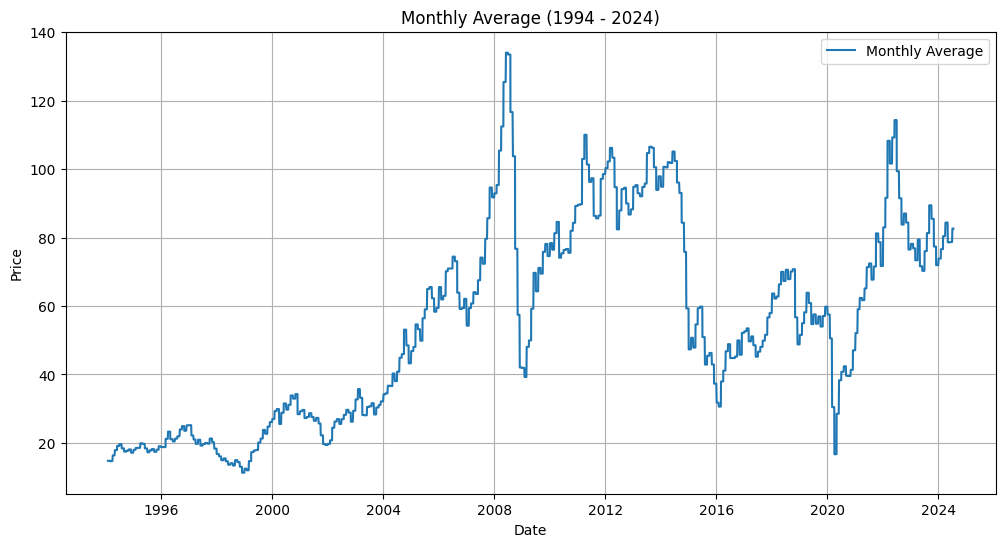

In [163]:
# Plotar gráficos para cada variável
variables = ['WTI Crude Oil Prices', 'S&P500', 'Gold', 'Silver', 'EUR/USD', 'EUR/RUB', 'Monthly Average']
for var in variables:
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data.index, filtered_data[var], label=var)
    plt.title(f'{var} (1994 - 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

## Describe

In [164]:
# Descrever as variáveis
description = filtered_data.describe()
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+------------------------+----------+----------+------------+-------------+-----------+-------------------+--------------------------+--------------+-------------------+
|       |   WTI Crude Oil Prices |   S&P500 |     Gold |     Silver |     EUR/USD |   EUR/RUB |   Monthly Average |   Previous Month Average |   WTI Target |   Cumulative Mean |
|-------+------------------------+----------+----------+------------+-------------+-----------+-------------------+--------------------------+--------------+-------------------|
| count |              7619      |  7619    | 7619     | 7619       | 7619        | 7619      |         7619      |                7619      |  7619        |         7619      |
| mean  |                54.96   |  1810.26 |  962.603 |   14.3206  |    1.19146  |   44.2818 |           54.96   |                  54.7854 |     0.59181  |           54.9473 |
| std   |                29.0518 |  1143.91 |  587.216 |    8.81181 |    0.148301 |   26.7932 |           28.9

In [165]:
# Calcular a matriz de correlação
correlation_matrix = filtered_data.corr()

## Heatmap das variáveis

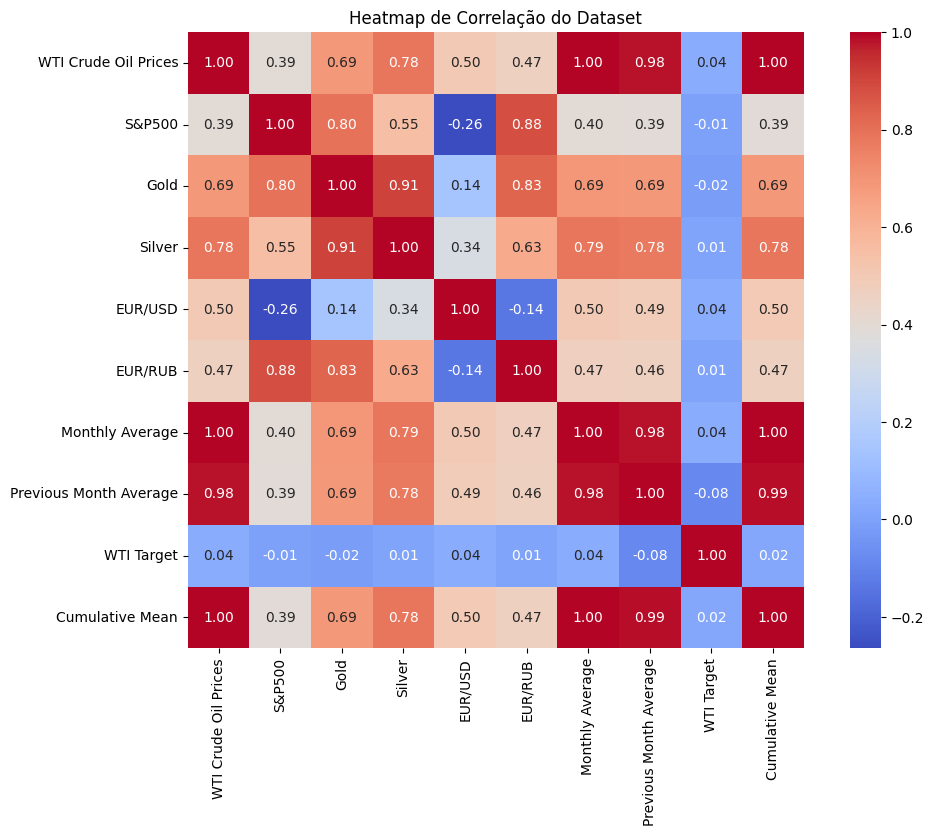

In [166]:
# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Modelo de Classificação

Usaram-se os modelos Random Forest, XGBoost e Decision Tree, assim como as métricas accuracy, precision e recall. O ratio do train-test split manteve-se em 80/20, bem como a função Shuffle = False. 

In [167]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [168]:
# Filtrar os dados entre as datas de 1994 e 2024
filtered_data = combined_data[(combined_data.index >= start_date) & (combined_data.index <= end_date)]

In [169]:
# Separar variáveis independentes (X) e dependente (y)
X = filtered_data.drop(columns=['WTI Target', 'Monthly Average'])
y = filtered_data['WTI Target']

In [170]:
# Dividir os dados em conjuntos de treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Scaling dos Dados

In [171]:
# Escalar os dados de treino
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [172]:
# Aplicar a mesma transformação ao conjunto de teste
X_test_scaled = scaler.transform(X_test)

## Modelos a ser usados

In [173]:
# Definir os modelos
models = {
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "XGBoost Classifier": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [184]:
# Função para treinar e avaliar os modelos
def train_evaluate_classifier(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    return accuracy, precision, recall, y_pred

## 3 métricas usadas

In [185]:
# Avaliar os modelos e armazenar os resultados
results = {}
for name, model in models.items():
    accuracy, precision, recall, y_pred = train_evaluate_classifier(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Predictions": y_pred
    }

In [186]:
# Criar tabela de resultados
table = [["Model", "Accuracy", "Precision", "Recall"]]
for name, metrics in results.items():
    table.append([
        name,
        f"{metrics['Accuracy']:.4f}",
        f"{metrics['Precision']:.4f}",
        f"{metrics['Recall']:.4f}"
    ])

## Tabela c/ os resultados

In [187]:
# Exibir os resultados
print(tabulate(table, headers="firstrow", tablefmt="github"))

| Model                    |   Accuracy |   Precision |   Recall |
|--------------------------|------------|-------------|----------|
| Decision Tree Classifier |     0.7434 |      0.7665 |   0.7835 |
| Random Forest Classifier |     0.5965 |      0.6906 |   0.5146 |
| XGBoost Classifier       |     0.8077 |      0.764  |   0.9534 |


In [230]:
y_hat = results['XGBoost Classifier']['Predictions']
# mask for third wednesday of the month
mask = X_test.index.weekday == 2
mask &= X_test.index.day >= 15
mask &= X_test.index.day <= 21

# on how many of the 3rd wednesdays (of each month) was the model correct?
(y_test[mask] == y_hat[mask]).sum() / sum(mask)

np.float64(0.8333333333333334)

In [221]:
def decision_cost_function(y_test: pd.Series, y_hat: np.array, price_per_liter: pd.Series):
    # mask for third wednesday of the month, ignore last wednesday
    mask = y_test.index.weekday == 2
    mask &= y_test.index.day >= 15
    mask &= y_test.index.day <= 21

    # dataframe from yhat and price
    df = pd.DataFrame({"y_hat": y_hat, "price_per_liter": price_per_liter}, index=y_test.index)
    df = df[mask]

    # if y_hat is 1, buy 2 months
    df["price bought"] = 0

    # first month if at the price of the month
    # if y_hat is 1, buy next month
    # for each month, check if that month's fuel has already been bought on previous month (i.e. price != 0)


    for i in range(len(df)):
        # if fuel has not been bought for this month yet, buy it
        if df.loc[df.index[i], "price bought"] == 0:
            df.loc[df.index[i], "price bought"] = df.loc[df.index[i], "price_per_liter"]

        # if prediction is that prices increases (y_hat == 1), buy next month for this month's price
        if df.loc[df.index[i], "y_hat"] == 1:
            df.loc[df.index[i + 1], "price bought"] = df.loc[df.index[i], "price_per_liter"]
    return df["price bought"]

In [222]:
pred_bought = decision_cost_function(y_test, y_hat, X_test["Previous Month Average"])

/tmp/ipykernel_1388313/2242029604.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.98318181818182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.index[i], "price bought"] = df.loc[df.index[i], "price_per_liter"]


In [224]:
wed_3rd_mask = y_test.index.weekday == 2
wed_3rd_mask &= y_test.index.day >= 15
wed_3rd_mask &= y_test.index.day <= 21

dumb_bought = X_test[wed_3rd_mask]["Previous Month Average"]
dumb_bought

Date
2018-06-20    69.983182
2018-07-18    67.322857
2018-08-15    70.581905
2018-09-19    67.845217
2018-10-17    70.084737
                ...    
2024-01-17    71.942105
2024-02-21    73.860952
2024-03-20    76.610000
2024-04-17    80.405000
2024-05-15    84.394091
Name: Previous Month Average, Length: 72, dtype: float64

In [225]:
pred_bought

Date
2018-06-20    69.983182
2018-07-18    67.322857
2018-08-15    67.322857
2018-09-19    67.845217
2018-10-17    67.845217
                ...    
2024-01-17    71.942105
2024-02-21    71.942105
2024-03-20    73.860952
2024-04-17    76.610000
2024-05-15    80.405000
Name: price bought, Length: 72, dtype: float64

In [226]:
dumb_bought.sum(), pred_bought.sum()

(np.float64(4871.5041365023235), np.float64(4716.457919442876))

In [227]:
dumb_bought.sum(), pred_bought.sum()

(np.float64(4871504.136502324), np.float64(4716457.919442876))

In [205]:
X_test

,WTI Crude Oil Prices,S&P500,Gold,Silver,EUR/USD,EUR/RUB,Previous Month Average,Cumulative Mean
Date,,,,,,,,
2018-06-19,65.07,2762.59,1274.66,16.3048,1.1590,74.0309,69.983182,65.728462
2018-06-20,66.22,2767.32,1267.86,16.2843,1.1572,73.5994,69.983182,65.763571
2018-06-21,65.54,2749.76,1267.19,16.3175,1.1604,73.8456,69.983182,65.748667
2018-06-22,68.58,2754.88,1270.56,16.4587,1.1651,73.5437,69.983182,65.925625
2018-06-25,68.08,2717.07,1265.64,16.3307,1.1704,73.6290,69.983182,66.052353
...,...,...,...,...,...,...,...,...
2024-07-08,82.33,5572.85,2359.13,30.7634,1.0824,95.1604,78.698421,83.112000
2024-07-09,81.41,5576.98,2364.09,30.8020,1.0813,95.5021,78.698421,82.828333
2024-07-11,82.62,5584.54,2415.48,31.4640,1.0868,95.1059,78.698421,82.798571


# Introdução do Grid Search

In [178]:
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
# Aplica o SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

## Parametrização

In [ ]:
# Definir parâmetros para grid search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

In [ ]:
# Instanciar os modelos
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

In [ ]:
# Criar GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy')
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy')

In [ ]:
# Treinar o GridSearchCV
grid_search_rf.fit(X_train_balanced, y_train_balanced)
grid_search_xgb.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [ ]:
# Melhor modelo de RandomForest
best_rf = grid_search_rf.best_estimator_

In [ ]:
# Melhor modelo de XGBoost
best_xgb = grid_search_xgb.best_estimator_

In [ ]:
# Avaliar o desempenho dos melhores modelos
models = [best_rf, best_xgb, DecisionTreeClassifier()]
model_names = ["Best Random Forest", "Best XGBoost", "Decision Tree Classifier"]

In [ ]:
results = {name: {} for name in model_names}
for model, name in zip(models, model_names):
    accuracy, precision, recall = train_evaluate_classifier(model, X_train_balanced, X_test, y_train_balanced, y_test)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall
    }

In [ ]:
# Exibir os resultados
table = [["Model", "Accuracy", "Precision", "Recall"]]
for name, metrics in results.items():
    table.append([
        name,
        f"{metrics['Accuracy']:.4f}",
        f"{metrics['Precision']:.4f}",
        f"{metrics['Recall']:.4f}"
    ])

## Resultados obtidos

In [ ]:
print(tabulate(table, headers="firstrow", tablefmt="github"))

| Model                    |   Accuracy |   Precision |   Recall |
|--------------------------|------------|-------------|----------|
| Best Random Forest       |     0.9725 |      1      |   0      |
| Best XGBoost             |     0.9686 |      0      |   0      |
| Decision Tree Classifier |     0.9372 |      0.0345 |   0.0476 |


Apesar de terem melhorado ainda não se obtiveram bons valores no recall nem na precision.

O facto de estarmos a olhar para a média das cotações do 1º dia útil de cada mês pode estar a influenciar, e temos também uma variável criada para a média das cotações do mês seguinte que pode não corresponder à verdade.

In [ ]:
filtered_data.head(64)

,WTI Crude Oil Prices,S&P500,Gold,Silver,EUR/USD,EUR/RUB,Monthly Average,Next Month Average,WTI Target
Date,,,,,,,,,
1994-01-04,14.67,466.89,393.85,5.24,1.1246,1.1088,15.052000,15.052000,0
1994-01-05,15.34,467.55,391.20,5.09,1.1252,1.1154,15.052000,15.052000,0
1994-01-06,15.42,467.12,388.90,5.12,1.1252,1.1189,15.052000,15.052000,0
1994-01-07,15.32,469.90,387.10,5.01,1.1293,1.1148,15.052000,15.052000,0
1994-01-10,14.67,475.27,384.60,5.04,1.1269,1.1305,15.052000,15.052000,0
...,...,...,...,...,...,...,...,...,...
1994-03-29,14.32,452.48,386.20,5.66,1.1712,1.4968,14.666957,14.666957,0
1994-03-30,14.38,445.55,386.40,5.64,1.1646,1.5052,14.666957,14.666957,0
1994-03-31,14.79,445.77,391.00,5.79,1.1737,1.4936,14.666957,16.366667,1


A variável Next_Month_Average tem os mesmos valores que a variável Monthly_Average, apenas atualiza esse valor no último dia de cada mês, o que deveria acontecer em todos os dias, ou seja, a variável Monthly_Average tem na mesma os mesmos valores para todos os dias do mês corrente, no entanto, o Next_Month_Average, deveria ter o valor da média das cotações do mês seguinte e não os do mês atual.

Posteriormente, o modelo apenas assume o valor de 1 no último dia de cada mês, o que não deveria acontecer. Aquilo que queremos perceber é se a média das cotações do mês seguinte será maior do que a do mês atual, pelo que se isso se verificar, o valor de 1 deverá aparecer no 1º dia útil de cada mês e permanecer até ao último dia útil desse mesmo mês.